* Import librairies

In [2]:
import os
import torch
from torch import nn # Neural Networks library
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms # Apply transformation on images (Data Augmentation)
from torchsummary import summary

* Download Multi-class Weather Dataset from kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pratik2901/multiclass-weather-dataset
!unzip 'multiclass-weather-dataset.zip'
!kaggle datasets download -d pratik2901/multiclass-weather-dataset
%cd "/content/Multi-class Weather Dataset"

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 83% 76.0M/91.4M [00:00<00:00, 189MB/s]
100% 91.4M/91.4M [00:00<00:00, 196MB/s]
Archive:  multiclass-weather-dataset.zip
  inflating: Multi-class Weather Dataset/Cloudy/cloudy1.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy10.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy100.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy101.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy102.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy103.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy104.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy105.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy106.jpg  
  inflating: Multi-class Weather Dat

* Load all images from dataset


In [4]:
# Define transformations to be apply on the images

IMAGE_SIZE = 128
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)), # Resize image to (128, 128)
    transforms.ToTensor(), # Scale image pixels to [0..1]
    ]
)

dataset = torchvision.datasets.ImageFolder(
        root="/content/Multi-class Weather Dataset", # data_path is path to directory
        transform=transform
)

print(dataset)

Dataset ImageFolder
    Number of datapoints: 1125
    Root location: /content/Multi-class Weather Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


* Divide dataset into train (70%) and test (30%) subsets

In [5]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(len(train_dataset), "train samples and", len(test_dataset), "test samples")

787 train samples and 338 test samples


* Create DataLoader object for train and test subsets

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 32,
                                           shuffle = True
)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = 32,
                                          shuffle = False
)

for batch_num, (image, target) in enumerate(train_loader):
  print("Batch image size", image.shape, "---- Batch label size", target.shape)

Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Ba

* Plot images from train_loader

Feature batch shape: torch.Size([32, 3, 128, 128])
Labels batch shape: torch.Size([32])


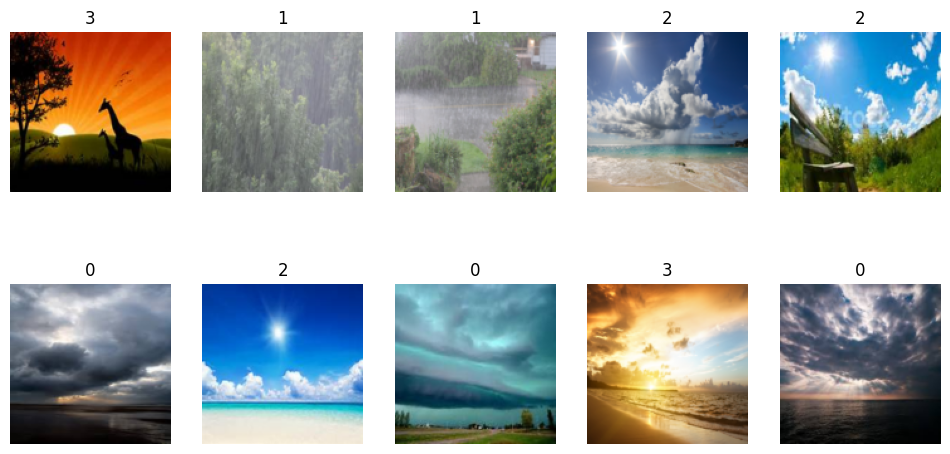

In [7]:
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 5, figsize=(12, 6))

for r in range(0, 2):
  for c in range(0, 5):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(transforms.ToPILImage()(img))
    axarr[r, c].set_title(str(label.item()))
    axarr[r, c].set_axis_off()
    indx+=1

* Implement MLP model:
  - First hidden layer : 128 neurons
  - Activation layer : ReLU
  - Second hidden layer : 64 neurons
  - Activation layer : ReLU
  - Output layer : 4 neurons
  - Activation layer : Softmax

In [8]:
class MLP (nn.Module):

  def __init__ (self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128*128*3, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 4),
        nn.Softmax(dim=1),
    )

  def forward(self, x):
    out = self.layers(x)
    return out

* Create MLP instance and turn it to CUDA device if available

In [9]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print("device:", device)

# create an instance of MLP
mlp = MLP()

# turn mlp in cuda if available
mlp.to(device)

device: cpu


MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=49152, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=4, bias=True)
    (6): Softmax(dim=1)
  )
)

* Show mlp summary

In [10]:
summary( mlp, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 49152]               0
            Linear-2                  [-1, 128]       6,291,584
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 4]             260
           Softmax-7                    [-1, 4]               0
Total params: 6,300,100
Trainable params: 6,300,100
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.38
Params size (MB): 24.03
Estimated Total Size (MB): 24.60
----------------------------------------------------------------


* Define Loss function and optimizer

In [11]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# optimizer Adam
optimizer = torch.optim.Adam(params =mlp.parameters(), lr=1e-4)

* Run the training Loop

In [12]:
epochs = 20

# set mlp model in train mode
mlp.train()

for epoch in range(epochs):

    # define a list to store the losses of the different batches
    losses = []

    # iter over patches
    for batch_num, (train_images, train_targets) in enumerate(train_loader):

        # initialize the optimizer (Zero the gradients)
        optimizer.zero_grad()

        # turn images and targets on cuda device if available
        train_images = train_images.to(device)
        train_targets = train_targets.to(device)

        # Propagate the images and return the predicted output (Perform forward pass)
        output = mlp(train_images)

        # calculate the loss between actual and predicted outputs (Compute loss)
        loss = loss_function(output, train_targets)

        # Add the loss of the current batch to losses list
        losses.append(loss.item())

        # Prpagate the gradient of the loss in reverse (Perform backward pass)
        loss.backward()
        # update the model parameters (Perform optimization)
        optimizer.step()

    print('Epoch %d -- Train Loss %.4f' % (epoch, sum(losses)/len(losses)))

# Process is complete.
print('Training process has finished.')

Epoch 0 -- Train Loss 1.2327
Epoch 1 -- Train Loss 1.0959
Epoch 2 -- Train Loss 1.0414
Epoch 3 -- Train Loss 1.0058
Epoch 4 -- Train Loss 0.9843
Epoch 5 -- Train Loss 0.9694
Epoch 6 -- Train Loss 0.9702
Epoch 7 -- Train Loss 0.9510
Epoch 8 -- Train Loss 0.9462
Epoch 9 -- Train Loss 0.9444
Epoch 10 -- Train Loss 0.9394
Epoch 11 -- Train Loss 0.9393
Epoch 12 -- Train Loss 0.9383
Epoch 13 -- Train Loss 0.9265
Epoch 14 -- Train Loss 0.9246
Epoch 15 -- Train Loss 0.9278
Epoch 16 -- Train Loss 0.9262
Epoch 17 -- Train Loss 0.9155
Epoch 18 -- Train Loss 0.9194
Epoch 19 -- Train Loss 0.9076
Training process has finished.


* Save the trained model

In [13]:
torch.save(mlp, 'mlp_model.pth')

* Load the model and run evaluation

In [14]:
# load the pretrained model saved in "mlp_model.pth"
path="mlp_model.pth"
mlp_model = torch.load(path)

# turn model in cuda device if available
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

mlp_model = mlp_model.to(device)

# set the model in evaluation mode to the modification of model pretrained parameters
mlp_model.eval()

total_samples = len(test_loader.dataset)
correct_samples = 0
total_loss = 0

# iter over batches
for num_batch, (test_images, test_targets) in enumerate(test_loader):

  # turn test_images and test_targets in cuda device
  test_images = test_images.to(device)
  test_targets = test_targets.to(device)

  # calculate logits (predictioh of the model)
  output = mlp_model(test_images)

  # calculate loss of the batch
  loss = loss_function(output, test_targets)
  total_loss += loss.item()

  # predict classes from outputs (class with the highest probability)
  pred_targets = output.argmax(dim=1)

  # calculate correct predictions
  nb_correct = pred_targets.eq(test_targets).sum()
  correct_samples += nb_correct

  avg_loss = total_loss / len(test_loader)
  val_accuracy = (correct_samples / total_samples)

print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  val_accuracy:' + '{:.4f}'.format(val_accuracy) + '\n')

<ipython-input-14-47adacc41ce3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model = torch.load(path)



Average test loss: 0.8961  val_accuracy:0.8521

